In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from typing import List
from tqdm import tqdm

In [ ]:
# !pip install implicit

In [ ]:
from google.colab import drive


#распаковать данные и провести анализ и обработку

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_users = pd.read_csv('/content/drive/MyDrive/2025Mag2/RecSys/DataSet/users.csv')
df_items = pd.read_csv('/content/drive/MyDrive/2025Mag2/RecSys/DataSet/items.csv')
df_interactions = pd.read_csv('/content/drive/MyDrive/2025Mag2/RecSys/DataSet/interactions.csv')

In [ ]:
df_items.head(5)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [ ]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       15963 non-null  int64  
 1   content_type  15963 non-null  object 
 2   title         15963 non-null  object 
 3   title_orig    11218 non-null  object 
 4   release_year  15865 non-null  float64
 5   genres        15963 non-null  object 
 6   countries     15926 non-null  object 
 7   for_kids      566 non-null    float64
 8   age_rating    15961 non-null  float64
 9   studios       1065 non-null   object 
 10  directors     14454 non-null  object 
 11  actors        13344 non-null  object 
 12  description   15961 non-null  object 
 13  keywords      15540 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB


In [ ]:
df_users.head(5)

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [ ]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   840197 non-null  int64 
 1   age       826102 non-null  object
 2   income    825421 non-null  object
 3   sex       826366 non-null  object
 4   kids_flg  840197 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 32.1+ MB


In [ ]:
# удаляем последнюю строку из interactions
df_interactions['last_watch_dt'] = pd.to_datetime(df_interactions['last_watch_dt'])
print(len(df_interactions))
df_interactions.drop(df_interactions.tail(1).index,inplace=True)
print(len(df_interactions))
df_interactions = df_interactions.assign(reallyWatched = df_interactions['watched_pct'] >= 50.0)

5476251
5476250


In [ ]:
uniq_users = df_users['user_id'].unique()
uniq_items = df_items['item_id'].unique()

In [ ]:
len(df_interactions)

5476250

In [ ]:
# Оставляем только те взаимодействия, Id пользователей и итемов которых есть в таблицах
df_interactions = df_interactions[df_interactions['user_id'].isin(df_users['user_id']) & df_interactions['item_id'].isin(df_items['item_id'])]

In [ ]:
len(df_interactions)

4424476

In [ ]:
df_interactions.head(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,reallyWatched
0,176549,9506,2021-05-11,4250,72.0,True
1,699317,1659,2021-05-29,8317,100.0,True
2,656683,7107,2021-05-09,10,0.0,False
3,864613,7638,2021-07-05,14483,100.0,True
4,964868,9506,2021-04-30,6725,100.0,True


In [ ]:
df_interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4424476 entries, 0 to 5476249
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   user_id        int64         
 1   item_id        int64         
 2   last_watch_dt  datetime64[ns]
 3   total_dur      int64         
 4   watched_pct    float64       
 5   reallyWatched  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 206.8 MB


In [ ]:
df_interactions.isnull().sum()

,0
user_id,0
item_id,0
last_watch_dt,0
total_dur,0
watched_pct,661
reallyWatched,0


In [ ]:
df_items.isnull().sum()

,0
item_id,0
content_type,0
title,0
title_orig,4745
release_year,98
genres,0
countries,37
for_kids,15397
age_rating,2
studios,14898


In [ ]:
df_users.isnull().sum()

,0
user_id,0
age,14095
income,14776
sex,13831
kids_flg,0


In [ ]:
import matplotlib.pyplot as plt


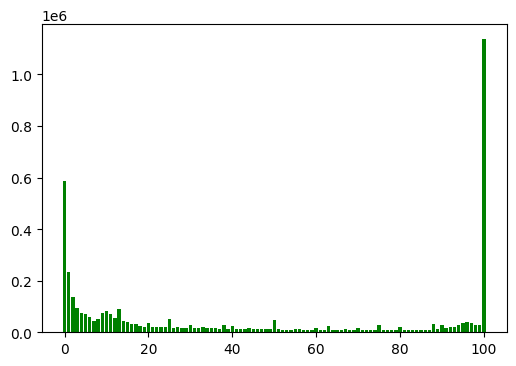

In [ ]:
watch = df_interactions['watched_pct'].value_counts()

plt.figure(figsize=(6,4))
plt.bar(watch.index, watch, color='green')
plt.show()
# по графику видно, что многие не досматривают даже до половины

In [ ]:
# количество взаимодействий, когда фильм был просмотрен > 85%
print(len(df_interactions[df_interactions['watched_pct']>85.0]))

1486979


In [ ]:
#Количество взаимодействий в каждом месяце
monthly = df_interactions.groupby(pd.Grouper(key='last_watch_dt', freq='M')).agg({
    'user_id':'count',
    'total_dur': 'sum'
}).rename(columns={'user_id': 'total_interactions'})
monthly
# ближе к лету просмотров стало больше

/tmp/ipython-input-475604197.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_interactions.groupby(pd.Grouper(key='last_watch_dt', freq='M')).agg({


,total_interactions,total_dur
last_watch_dt,,
2021-03-31,228807,1325997399
2021-04-30,445931,2597646720
2021-05-31,626669,4369379772
2021-06-30,934560,8932255781
2021-07-31,1177157,10105828451
2021-08-31,1011352,6660857785


<Axes: xlabel='last_watch_dt', ylabel='total_interactions'>

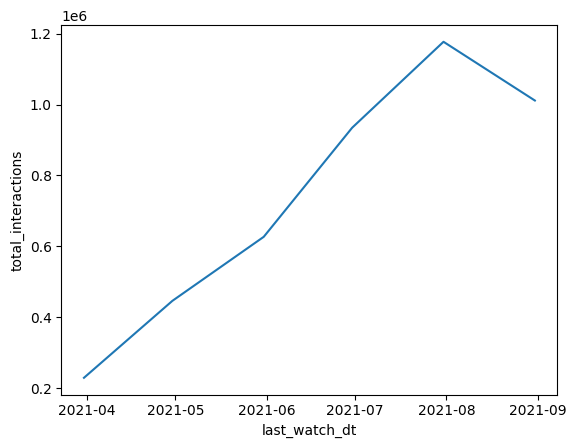

In [ ]:
import seaborn as sns
sns.lineplot(data=monthly, x='last_watch_dt', y='total_interactions')

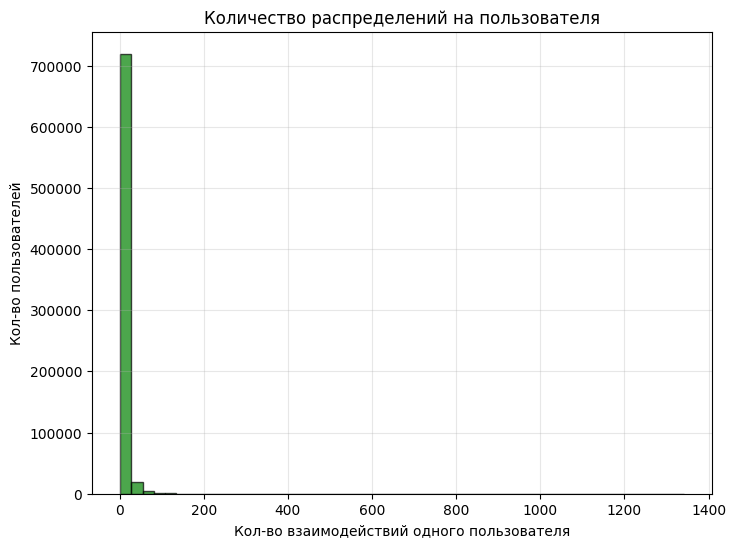

In [ ]:
user_activity = df_interactions.groupby('user_id').size().reset_index(name='interac_count')

plt.figure(figsize=(8,6))
plt.hist(user_activity['interac_count'], bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Количество распределений на пользователя')
plt.xlabel('Кол-во взаимодействий одного пользователя')
plt.ylabel('Кол-во пользователей')
plt.grid(alpha=0.3)
plt.show()

# Большинство пользователей смотрят не более 5-10

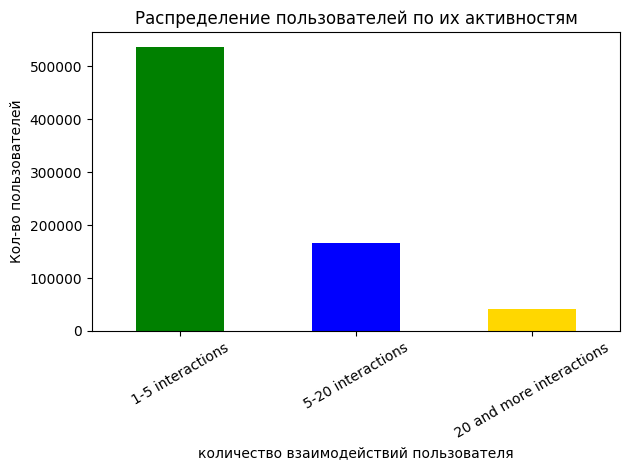

In [ ]:
def seg_by_activity(count):
    if 1 <= count <= 5:
        return '1-5 interactions'
    elif 5 < count <= 20:
        return '5-20 interactions'
    elif 20 < count:
        return '20 and more interactions'
    else:
      return "none interactions"

user_activity['activity_seg'] = user_activity['interac_count'].apply(seg_by_activity)

seg_counts = user_activity['activity_seg'].value_counts()

seg_counts.plot(kind='bar', color=['green', 'blue', 'gold', 'red'])
plt.title('Распределение пользователей по их активностям')
plt.xlabel('количество взаимодействий пользователя')
plt.ylabel('Кол-во пользователей')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


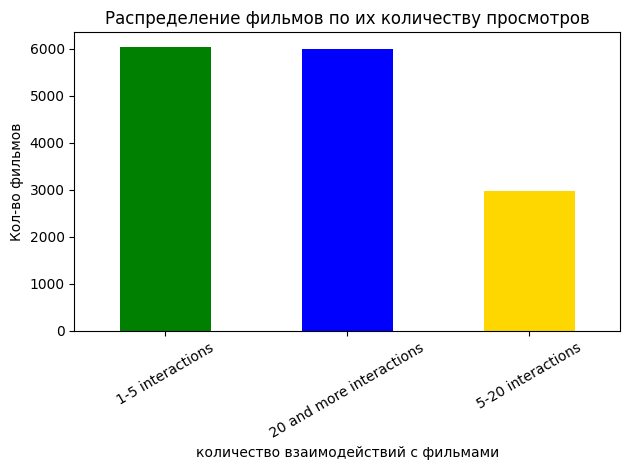

In [ ]:
item_activity = df_interactions.groupby('item_id').size().reset_index(name='interac_count')
item_activity['activity_seg'] = item_activity['interac_count'].apply(seg_by_activity)

seg_counts = item_activity['activity_seg'].value_counts()

seg_counts.plot(kind='bar', color=['green', 'blue', 'gold', 'red'])
plt.title('Распределение фильмов по их количеству просмотров')
plt.xlabel('количество взаимодействий с фильмами')
plt.ylabel('Кол-во фильмов')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


#Сформировать набор данных

In [ ]:
# параметр K
k = 10

test_size_days = 7
dateColumnName = "last_watch_dt"
userColumnName = "user_id"
watchdPrcntColumnName = "watched_pct"
itemIdColumnName = "item_id"
totalDurColumnName = "total_dur"
reallyWatchedColumn = "reallyWatched"

In [ ]:
from datetime import datetime, timedelta

# Получение даты с которой начинается тестовый набор
def getLastWeekFirstDay(lastDate, test_size_days=7):
    return lastDate - timedelta(days=(test_size_days-1))

In [ ]:
# получение тренировочного и тестового наборов по дням
def splitByLastDate(df_interactions, test_size_days = 7):
  # Получаем последнюю дату
  maxDate = df_interactions[dateColumnName].max()
  lastWeekFirstDate = getLastWeekFirstDay(maxDate, test_size_days)
  print(lastWeekFirstDate)
  data_train = df_interactions[df_interactions[dateColumnName] < lastWeekFirstDate]
  data_test = df_interactions[df_interactions[dateColumnName] >= lastWeekFirstDate]
  return data_train, data_test

In [ ]:
df_interactions_train, df_interactions_test = splitByLastDate(df_interactions, test_size_days)

2021-08-16 00:00:00


In [ ]:
df_interactions_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 335033 entries, 54 to 5476248
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        335033 non-null  int64         
 1   item_id        335033 non-null  int64         
 2   last_watch_dt  335033 non-null  datetime64[ns]
 3   total_dur      335033 non-null  int64         
 4   watched_pct    335032 non-null  float64       
 5   reallyWatched  335033 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 15.7 MB


In [ ]:
df_interactions_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4089443 entries, 0 to 5476249
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   user_id        int64         
 1   item_id        int64         
 2   last_watch_dt  datetime64[ns]
 3   total_dur      int64         
 4   watched_pct    float64       
 5   reallyWatched  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 191.1 MB


In [ ]:
def filter_userInteractions(df):
  # df_Temp = df.copy()
  # df_Temp["grouped"] = df.groupby(userColumnName)[itemIdColumnName].unique().reset_index()
  df_Temp = df.groupby(userColumnName)[itemIdColumnName].unique().reset_index()
  df_Temp.columns = [userColumnName, itemIdColumnName]
  print(len(df_Temp))
  filtered_df_Temp = df_Temp[df_Temp[itemIdColumnName].apply(lambda x: len(x)>3)]
  unique_users = filtered_df_Temp[userColumnName].unique()
  print(len(unique_users))
  return df[df[userColumnName].isin(unique_users)]



In [ ]:
df_interactions_train = filter_userInteractions(df_interactions_train)


703552
277310


In [ ]:
df_interactions_test = filter_userInteractions(df_interactions_test)

131495
25587


In [ ]:
df_interactions_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175703 entries, 64 to 5476201
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        175703 non-null  int64         
 1   item_id        175703 non-null  int64         
 2   last_watch_dt  175703 non-null  datetime64[ns]
 3   total_dur      175703 non-null  int64         
 4   watched_pct    175703 non-null  float64       
 5   reallyWatched  175703 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 8.2 MB


In [ ]:
df_interactions_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3412999 entries, 0 to 5476249
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   user_id        int64         
 1   item_id        int64         
 2   last_watch_dt  datetime64[ns]
 3   total_dur      int64         
 4   watched_pct    float64       
 5   reallyWatched  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 159.5 MB


In [ ]:
# достать уникальных пользователей из train
train_unique_users = df_interactions_train[userColumnName].unique()
test_unique_users = df_interactions_test[userColumnName].unique()

test_unique_items = df_interactions_test[itemIdColumnName].unique()
train_unique_items = df_interactions_train[itemIdColumnName].unique()

In [ ]:
len(test_unique_users)

25587

In [ ]:
# отфильтровать валидные случаи
user_tests_content_interaction = df_interactions_test[((df_interactions_test[reallyWatchedColumn] == True))]

In [ ]:
user_tests_content_interaction_Really = df_interactions_test[((df_interactions_test[reallyWatchedColumn] == True))]
user_train_content_interaction_Really = df_interactions_train[((df_interactions_train[reallyWatchedColumn] == True))]

In [ ]:
test_unique_items_really = user_tests_content_interaction_Really[itemIdColumnName].unique()
train_unique_items_really = user_train_content_interaction_Really[itemIdColumnName].unique()

In [ ]:
user_tests_content_interaction = df_interactions_test.groupby(userColumnName)[itemIdColumnName].unique().reset_index()

In [ ]:
user_tests_content_interaction.columns = [userColumnName, itemIdColumnName]

In [ ]:
user_tests_content_interaction

,user_id,item_id
0,117,"[12421, 10198, 12192, 16509]"
1,241,"[6162, 2356, 10440, 8986, 12138, 2025]"
2,272,"[15214, 5398, 9728, 15894, 6561, 3190, 13545, ..."
3,322,"[11099, 9265, 633, 12356]"
4,339,"[16413, 15384, 512, 10774]"
...,...,...
25582,1097471,"[10942, 682, 1785, 4927]"
25583,1097473,"[4537, 12133, 4255, 16270, 12908]"
25584,1097479,"[4038, 9563, 7128, 14884]"
25585,1097486,"[8419, 931, 14025, 1916]"


In [ ]:
filtered_user_tests_content_interaction = user_tests_content_interaction[user_tests_content_interaction[itemIdColumnName].apply(lambda x: len(x)>1)]


In [ ]:
filtered_user_tests_content_interaction

,user_id,item_id
0,117,"[12421, 10198, 12192, 16509]"
1,241,"[6162, 2356, 10440, 8986, 12138, 2025]"
2,272,"[15214, 5398, 9728, 15894, 6561, 3190, 13545, ..."
3,322,"[11099, 9265, 633, 12356]"
4,339,"[16413, 15384, 512, 10774]"
...,...,...
25582,1097471,"[10942, 682, 1785, 4927]"
25583,1097473,"[4537, 12133, 4255, 16270, 12908]"
25584,1097479,"[4038, 9563, 7128, 14884]"
25585,1097486,"[8419, 931, 14025, 1916]"


In [ ]:
len(filtered_user_tests_content_interaction)

25587

In [ ]:
def precision(recommended_list, bought_list):

    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)

    flags = np.isin(bought_list, recommended_list)

    precision = flags.sum() / len(recommended_list)

    return precision


def precision_at_k(recommended_list, bought_list, k=5):

    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)

    #assert len(bought_list) > len(recommended_list)
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]

    flags = np.isin(bought_list, recommended_list)

    precision = flags.sum() / len(recommended_list)


    return precision


def money_precision_at_k(recommended_list, bought_list, prices_recommended, k=5):

    # your_code
    # Лучше считать через скалярное произведение, а не цикл
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]

    flags = np.isin(bought_list, recommended_list)

    precision = np.dot(flags, bought_list) / np.sum(recommended_list)
    return precision

In [ ]:
def recall(recommended_list, bought_list):

    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)

    flags = np.isin(bought_list, recommended_list)

    recall = flags.sum() / len(bought_list)

    return recall


def recall_at_k(recommended_list, bought_list, k=5):

    # your_code
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list[:k])

    flags = np.isin(bought_list, recommended_list)

    recall = flags.sum() / len(bought_list)

    return recall


def money_recall_at_k(recommended_list, bought_list, prices_recommended, prices_bought, k=5):

    # your_code
    bought_list = np.array(bought_list)
    recommended_list = recommended_list[:k]

    flags = np.isin(bought_list, recommended_list)

    recall = np.dot(flags, bought_list) / np.sum(bought_list)

    return recall

In [ ]:
def ap_k(recommended_list, bought_list, k=5):
    # print("=",bought_list, recommended_list)
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    flags = np.isin(recommended_list, bought_list)
    # if (np.isin([True],flags)[0]):
    #   print(flags)
    if sum(flags) == 0:
        return 0

    sum_ = 0
    for i in range(0, k-1):
        if flags[i] == True:
            p_k = precision_at_k(recommended_list, bought_list, k=i+1)
            sum_ += p_k

    result = sum_ / sum(flags)

    return result

In [ ]:
# получение списка взаимодействий юзера
def getUserItems(userInteractionItems, user_id):
  return userInteractionItems[(userInteractionItems[userColumnName] == user_id)][itemIdColumnName].values[0]

In [ ]:
# получение значения из матрицы по двум столбцам
def getColFromBy2Col(Items, first_column, second_column, first_c_id):
  return Items[(Items[first_column] == first_c_id)][second_column]

In [ ]:
# получение значения из матрицы по двум столбцам
def getValueFromBy2Col(Items, first_column, second_column, first_c_id):
  colFromBy2Col = getColFromBy2Col(Items, first_column, second_column, first_c_id)
  # print(colFromBy2Col)
  if len(colFromBy2Col) > 0:
    return colFromBy2Col.values[0]
  else:
    return None

#random

In [ ]:
# def getRandomRecommendOLD(items, k=10):
#   return items[itemIdColumnName].sample(k,replace=True).tolist()

# def getRandomRecommendOLDOLD(items, k=10):
#   return pd.Series(items[itemIdColumnName].unique()).sample(k,replace=True).tolist()

def getRandomRecommend(items, k=10):
  return np.random.choice(items, k)

In [ ]:
def getFirstK(items, k=10):
  return items[:k]

In [ ]:
# item = рекомендации взять из тестового набора
def map_k(items, userContentInteractions, func, k=10):
    user_ids = userContentInteractions[userColumnName].tolist()
    result = [ap_k(func(items, k), getUserItems(userContentInteractions, i)) for i in user_ids]
    return np.average(result)

#popular

In [ ]:
# Получение популярных items по всем
def getPopularItems(df):
  items_content_interaction_Pop = df.groupby(itemIdColumnName)[watchdPrcntColumnName].unique().reset_index()
  items_content_interaction_Pop.columns = [itemIdColumnName, watchdPrcntColumnName]
  items_content_interaction_Pop[watchdPrcntColumnName] = items_content_interaction_Pop[watchdPrcntColumnName].apply(lambda x: len(np.array(x)))
  items_content_interaction_Pop = items_content_interaction_Pop.sort_values(by=watchdPrcntColumnName, ascending=False)
  return items_content_interaction_Pop[itemIdColumnName].unique()

#Popular+UPopular

In [ ]:
def sumColVal(x):
  print(x)
  return (len(x[1]))

#ЗАДАЧА 2

In [ ]:
all_users = df_interactions[userColumnName].unique()


In [ ]:
# получить интеракции пользователя
def get_user_interactions(user_id, df_interactions):
  return df_interactions[((df_interactions[userColumnName] == user_id))]

def getUniqueColumnValues(df, columnName):
  return df[columnName].unique()

In [ ]:
import random

#Получение случайного пользователя со списком взаимодействий > k
def getRandomUser(df_interactions, k = 10):
  random_user_interactions = []
  while len(random_user_interactions) < k:
    random_user = random.choice(all_users)
    random_user_interactions = get_user_interactions(random_user, df_interactions)
  return random_user_interactions

In [ ]:
# получение строк только по вхождениям из списка
def getitemsByList(df,columnName, list_of_users):
  return df[df[columnName].isin(list_of_users)]

In [ ]:
releaseYearCol = 'release_year'
genresCol = 'genres'
actorsCol = 'actors'
directorsCol = 'directors'

In [ ]:
def getArrayFromDF(df, columnName):
  return df[columnName].apply(lambda x: x.split(', '))

In [ ]:
# Условия для itemXitem

# тот-же год
def sameYearDF(df, year):
  conditions = [
    (df[releaseYearCol] == year),
    (df[releaseYearCol] != year)
  ]
  choices = [0.25, 0]
  return np.select(conditions, choices)

# Хотя бы один жанр
def sameGenreDF(df, genres):
  conditions = [
    (df[genresCol].str.contains('|'.join(genres)) == True),
    (df[genresCol].str.contains('|'.join(genres)) != True)
  ]
  choices = [0.25, 0]
  return np.select(conditions, choices)

# Хотя бы один актер
def sameActorDF(df, actors):
  conditions = [
    (df[actorsCol].str.contains('|'.join(actors)) == True),
    (df[actorsCol].str.contains('|'.join(actors)) != True)
  ]
  choices = [0.25, 0]
  return np.select(conditions, choices)

# Хотя бы один режиссер
def sameDirectorDF(df, directors):
  conditions = [
    (df[directorsCol].str.contains('|'.join(directors)) == True),
    (df[directorsCol].str.contains('|'.join(directors)) != True)
  ]
  choices = [0.25, 0]
  return np.select(conditions, choices)

##############################################
# Условия для userXitem

# # Сравнить по проценту просмотренного
# def compareWatchedDF(df, watchPrcnt):
#   conditions = [
#     (df[watchdPrcntColumnName] >= watchPrcnt),
#     (df[watchdPrcntColumnName] < watchPrcnt)
#   ]
#   choices = [1, 0]
#   return np.select(conditions, choices)

# Сравнить по проценту просмотренного и по диапазону дат
def sameDateWatchedDF(df, time_from, time_to):
  conditions = [
    ((df[dateColumnName] > time_from) & (df[dateColumnName] < time_to)== True),
    ((df[dateColumnName] > time_from) & (df[dateColumnName] < time_to) != True)
  ]
  choices = [0.7, 0]
  return np.select(conditions, choices)

# Сравнить по полу пользователя
def sameGenderDF(df_u, sex, actual_info_u):
  conditions = [
    ((df_u[userColumnName].isin(actual_info_u)) !=True),
    ((df_u['sex'] == sex) == True),
    ((df_u['sex'] == sex) != True)
  ]
  choices = [0, 1, 0.1]
  return np.select(conditions, choices)



In [ ]:
def getCoeff(b,itemId, c = 0.25):
  # b.replace(np.nan, False, inplace=True)
  # print(c if b.get(itemId) else 0)
  # print(b.size)
  return c if b.get(itemId) == True else 0

In [ ]:
def convertToArray(df, col1, col2, id):
  data = getValueFromBy2Col(df, col1, col2, id)
  return data.split(', ') if type(data) == 'str'else []


In [ ]:
# def userKNN(df_interactions_test, df_interactions_train, df_items, df_users, k=10, interrupt = False):


In [ ]:
def map_k_KNN_users_test(df_interactions_test, df_interactions_train, df_items, df_users, k=10, interrupt = False):
  # получаем всех юзеров из тестового и тренировочного набора
  all_test_users = getUniqueColumnValues(df_interactions_test, userColumnName)
  all_train_users = getUniqueColumnValues(df_interactions_train, userColumnName)
  # all_test_users = [all_test_users[1814]]
  # Получаем списко самых популярных впринципе из Train
  list_all_popular = getPopularItems(df_interactions_train)

  # Все
  # user_tests_content_interaction = df_interactions_test.groupby(userColumnName)[itemIdColumnName].unique().reset_index()
  # user_tests_content_interaction.columns = [userColumnName, itemIdColumnName]

  sum_ap_k = 0 # сумма значений метрики ap k
  userRecomenadations = 0 # просмотренные пользователи с рекомендациями
  counter = 0
  len_test = len(all_test_users)
  # для каждого пользователя находим рекоммендации
  for user_id in all_test_users:

    counter += 1
    all_test_items = getColFromBy2Col(df_interactions_test, userColumnName, itemIdColumnName, user_id).unique()

    # если в тесте меньше 5 взаимодействий, значит и рекомендовать ему нечего
    if len(all_test_items) > 4:
      # получаем все items из train у юзера
      all_train_items = getColFromBy2Col(df_interactions_train, userColumnName, itemIdColumnName, user_id).unique()
      # Если нету такого пользователя в Train или мало , то рекомендуем ему популярные ('Холодный старт')
      is_all_train_items = len(all_train_items) > 0
      recomendations = []
      if (is_all_train_items):
        user_interactions_train = get_user_interactions(user_id, df_interactions_train)
        user_Item_Train_df = pd.DataFrame()
        users_serie = pd.Series(all_train_users)
        user_Item_Train_df = pd.concat([user_Item_Train_df, users_serie.rename(userColumnName)], axis=1)

        # Заполняем матрицу user+item
        # 3 недели
        time_delta_days = np.timedelta64(30, 'D')
        user_sex = getValueFromBy2Col(df_users, userColumnName, 'sex', user_id)
        print(len(all_train_items))
        for itemId in all_train_items:
          time_from = getValueFromBy2Col(user_interactions_train, itemIdColumnName, dateColumnName, itemId) - time_delta_days
          time_to = getValueFromBy2Col(user_interactions_train, itemIdColumnName, dateColumnName, itemId) + time_delta_days

          actual_interactions = df_interactions_train[(df_interactions_train[dateColumnName] > time_from) & (df_interactions_train[dateColumnName] < time_to)]
          uniq_actual_users = actual_interactions[userColumnName].unique()
          isSameGenderDF = sameGenderDF(df_users, user_sex, uniq_actual_users)
          values_uI = pd.Series(isSameGenderDF)
          user_Item_Train_df = pd.concat([user_Item_Train_df, values_uI.rename(itemId)], axis=1)


        cols_items = all_train_items
        # берем тех юзеров, у которых совпадение хотя бы по одному фильму
        temp_df_user_item = user_Item_Train_df[user_Item_Train_df[cols_items].sum(axis=1) >= 1]
        # подсчитаем сумму все х совпадений по экземплярам и отсортируем
        if len(cols_items) > 1:
          temp_df_user_item.insert(1, 'sumCount', temp_df_user_item[cols_items].sum(axis=1))
        else:
          temp_df_user_item["sumCount"] = temp_df_user_item[cols_items[0]]
        temp_df_user_item.sort_values(by='sumCount', ascending=False)

        unique_users_List_Train = temp_df_user_item[userColumnName].unique()
        unique_user_Interactions_Train = getitemsByList(df_interactions_train, userColumnName, unique_users_List_Train)
        unique_user_Interactions_Train = unique_user_Interactions_Train.drop_duplicates(subset=[itemIdColumnName], keep=False)  # С использованием keep=False дубликаты не сохраняются!
        selected_items_train_df = getitemsByList(df_items, itemIdColumnName, unique_user_Interactions_Train[itemIdColumnName].unique())
        unique_user_Interactions_Train_df = pd.DataFrame(selected_items_train_df[itemIdColumnName])

        # получаем матрицу item+item
        for itemId in all_train_items:
          release_year = getValueFromBy2Col(df_items, itemIdColumnName, releaseYearCol, itemId)
          genres = convertToArray(df_items, itemIdColumnName, genresCol, itemId)
          actors = convertToArray(df_items, itemIdColumnName, actorsCol, itemId)
          directors = convertToArray(df_items, itemIdColumnName, directorsCol, itemId)

          isSameGenre = sameGenreDF(selected_items_train_df,genres)
          isSameYear = sameYearDF(selected_items_train_df,release_year)
          isSameActor = sameActorDF(selected_items_train_df,actors)
          isSameDirector = sameDirectorDF(selected_items_train_df,directors)
          values = pd.Series(isSameGenre + isSameYear + isSameActor + isSameDirector)

          unique_user_Interactions_Train_df = pd.concat([unique_user_Interactions_Train_df, values.rename(itemId)], axis=1)


        # берем тех items, у которых совпадение в сумме дает 1
        temp_df_item_item = unique_user_Interactions_Train_df[unique_user_Interactions_Train_df[cols_items].sum(axis=1) >= 1]
        # сортируем
        if len(cols_items) > 1:
          temp_df_item_item.insert(1, 'sumCount', temp_df_item_item[cols_items].sum(axis=1))
        else:
          temp_df_item_item["sumCount"] = temp_df_item_item[cols_items[0]]
        temp_df_item_item.sort_values(by='sumCount', ascending=False)

        # топ k
        recomendations = temp_df_item_item.head(k)[itemIdColumnName].unique()
        # если все рекомендации то считаем ap_k
        if len(recomendations) == k:
          sum_ap_k += ap_k(recomendations, all_test_items)

      # Если нету такого пользователя в Train, то рекомендуем ему популярные ('Холодный старт')
      # Или если в рекомедациях не набралось k экземпляров, дополняем их популярными
      if (is_all_train_items == False or len(recomendations)<k):
        dif_k = k - len(recomendations)
        list_recommend = []
        # дополняем список рекомендуемых экземплярами из популярного
        if dif_k>0:
          list_recommend = np.concatenate([recomendations, getFirstK(list_all_popular, dif_k)])
        else:
          list_recommend = recomendations
        sum_ap_k += ap_k(list_recommend, all_test_items)

      # + счетчик рекомендаций
      userRecomenadations += 1
    # if (counter % 50 == 0):
    print('_____________________',counter, ' / [',userRecomenadations,' ]/ [mapK = ',sum_ap_k/userRecomenadations,']', len_test)
    if interrupt == True and userRecomenadations == 100:
      break

  return sum_ap_k/userRecomenadations



In [ ]:
unique_users_test = df_interactions_test[userColumnName].unique()
unique_users_train = df_interactions_train[userColumnName].unique()

In [ ]:
# оставляем только тех пользователей, которые есть в interactions
df_filtered_users = df_users[df_users[userColumnName].isin(np.concatenate((unique_users_test, unique_users_train)))]

In [ ]:
print(len(df_users), len(df_filtered_users))

840197 287078


In [ ]:
mapk_KNN = map_k_KNN_users_test(df_interactions_test, df_interactions_train, df_items, df_filtered_users, k)

Выходные данные были обрезаны до нескольких последних строк (5000).
_____________________ 730  / [ 597  ]/ [mapK =  0.0064209938581797875 ] 25587
_____________________ 731  / [ 598  ]/ [mapK =  0.00641025641025641 ] 25587
16
_____________________ 732  / [ 599  ]/ [mapK =  0.006399554813578186 ] 25587
_____________________ 733  / [ 600  ]/ [mapK =  0.006388888888888888 ] 25587
_____________________ 734  / [ 601  ]/ [mapK =  0.006378258458125346 ] 25587
_____________________ 735  / [ 602  ]/ [mapK =  0.00636766334440753 ] 25587
4
_____________________ 736  / [ 603  ]/ [mapK =  0.006357103372028745 ] 25587
_____________________ 737  / [ 603  ]/ [mapK =  0.006357103372028745 ] 25587
_____________________ 738  / [ 604  ]/ [mapK =  0.006346578366445916 ] 25587
38
_____________________ 739  / [ 605  ]/ [mapK =  0.006336088154269972 ] 25587
5
_____________________ 740  / [ 606  ]/ [mapK =  0.0063256325632563256 ] 25587
39
_____________________ 741  / [ 607  ]/ [mapK =  0.006315211422295442 ] 2

KeyboardInterrupt: 

 Для объединенной метрики UserKNN + ItemKNN
 На 3980 людях mapK = 0.62%

In [ ]:
mapk_KNN

In [ ]:
1814

1814